<div style='background-image: url("./title01.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px'>
<div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
<div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computers, Waves, Simulations</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">The Pseudo-Spectral Method - Elastic Wave Equation 1D</div>
        </div>
    </div>
</div>

This notebook covers the following aspects:
* Initialize the Chebyshev derivative matrix $D_{ij}$ and display the Chebyshev derivative matrix
* Define and initialize space, material and source parameters 
* Extrapolate time using the previously defined Chebyshev derivative matrix 


## Basic Equations
This notebook presents the numerical solution for the 1D elastic wave equation using the Chebyshev Pseudospectral Method. We depart from the equation 

\begin{equation}
\rho(x) \partial_t^2 u(x,t) = \partial_x (\mu(x) \partial_x u(x,t)) + f(x,t),
\end{equation}

and use a standard 3-point finite-difference operator to approximate the time derivatives. Then, the displacement field is extrapolated as

\begin{equation}
\rho_i\frac{u_{i}^{j+1} - 2u_{i}^{j} + u_{i}^{j-1}}{dt^2}= \partial_x (\mu(x) \partial_x u(x,t))_{i}^{j} + f_{i}^{j}
\end{equation}

An alternative way of performing space derivatives of a function defined on the Chebyshev collocation points is to define a derivative matrix $D_{ij}$

\begin{equation}
D_{ij} =
  \begin{cases}
    -\frac{2 N^2 + 1}{6} \hspace{1.5cm} \text{for  i  = j = N}\\
    -\frac{1}{2} \frac{x_i}{1-x_i^2} \hspace{1.5cm} \text{for i = j = 1,2,...,N-1}\\
    \frac{c_i}{c_j} \frac{(-1)^{i+j}}{x_i - x_j} \hspace{1.5cm} \text{for i $\neq$ j = 0,1,...,N}
  \end{cases}
\end{equation}

where $N+1$ is the number of Chebyshev collocation points $ \ x_i = cos(i\pi / N)$, $ \ i=0,...,N$ and the $c_i$ are given as

$$ c_i = 2 \hspace{1.5cm} \text{for  i  = 0 or N} $$
$$ c_i = 1 \hspace{1.5cm} \text{otherwise} $$

This differentiation matrix allows us to write the derivative of the function $f_i = f(x_i)$ (possibly depending on time) simply as

$$\partial_x u_i = D_{ij} \ u_j$$

where the right-hand side is a matrix-vector product, and the Einstein summation convention applies.

In [1]:
# This is a configuration step for the exercise. Please run it before calculating the derivative!
import numpy as np
import matplotlib
# Show Plot in The Notebook
# -----------------------
matplotlib.use("nbagg")
import matplotlib.pyplot as plt

# Import python function from the file "ricker.py"
# -----------------------
from ricker import ricker 

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

### 1. Chebyshev derivative method


<IPython.core.display.Javascript object>


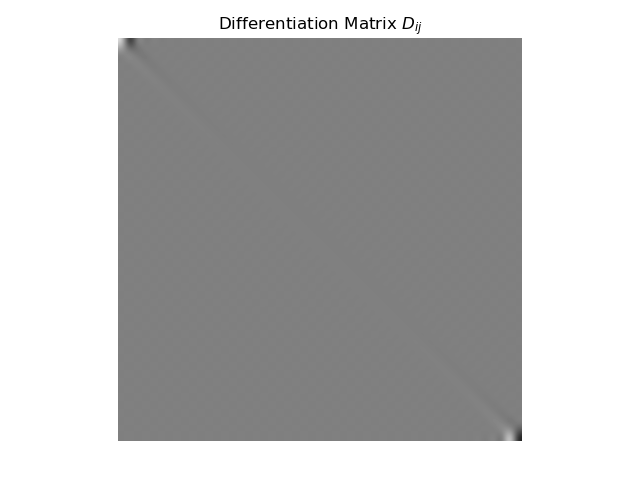

In [2]:
# Define Function that initializes the Chebyshev derivative matrix D_{ij} 
def get_cheby_matrix(nx):
    cx = np.zeros(nx+1)
    x = np.zeros(nx+1)
    for ix in range(0,nx+1):
        x[ix] = np.cos(np.pi * ix / nx)
   
    cx[0] = 2.
    cx[nx] = 2.
    cx[1:nx] = 1.
   
    D = np.zeros((nx+1,nx+1))
    for i in range(0, nx+1):
        for j in range(0, nx+1):
            if i==j and i!=0 and i!=nx:
                D[i,i]=-x[i]/(2.0*(1.0-x[i]*x[i]))
            else:
                D[i,j]=(cx[i]*(-1)**(i+j))/(cx[j]*(x[i]-x[j]))
  
    D[0,0] = (2.*nx**2+1.)/6.
    D[nx,nx] = -D[0,0]
    return D 

# Call the chebyshev differentiation matrix
# ---------------------------------------------------------------
D_ij = get_cheby_matrix(50)

# ---------------------------------------------------------------
# Display Differentiation Matrix
# ---------------------------------------------------------------
plt.imshow(D_ij, interpolation="bicubic", cmap="gray")
plt.title('Differentiation Matrix $D_{ij}$')
plt.axis("off")
plt.tight_layout()
plt.show()

### 2. Initialization of setup

In [3]:
# Basic parameters
# ---------------------------------------------------------------
#nt = 5000        # number of time steps
tmax  = 0.0006
eps   = 1.4       # stability limit
isx   = 100
lw    = 0.7
ft    = 10
f0    = 100000    # dominant frequency
iplot = 20        # Snapshot frequency

# material parameters
rho = 2500.
c   = 3000.
mu  = rho*c**2

# space domain
nx = 100     # number of grid points in x 199
xs = np.floor(nx/2)      # source location
xr = np.floor(nx*0.8)
x  = np.zeros(nx+1) 

# initialization of pressure fields
p = np.zeros(nx+1) 
pnew = np.zeros(nx+1)
pold = np.zeros(nx+1)
d2p  = np.zeros(nx+1) 

for ix in range(0,nx+1):
    x[ix] = np.cos(ix * np.pi / nx) 
dxmin = min(abs(np.diff(x)))
dxmax = max(abs(np.diff(x)))

dt = eps*dxmin/c    # calculate time step from stability criterion
nt = int(round(tmax/dt))

### 3. Source Initialization 

In [4]:
# source time function
# ---------------------------------------------------------------
t = np.arange(1, nt+1)*dt  # initialize time axis
T0 = 1./f0
tmp = ricker(dt, T0)
isrc = tmp
tmp = np.diff(tmp)
src = np.zeros(nt) 
src[0:np.size(tmp)] = tmp

#spatial source function
# ---------------------------------------------------------------
sigma = 1.5*dxmax
x0 = x[int(xs)]
sg = np.exp(-1/sigma**2*(x-x0)**2)
sg = sg/max(sg) 

### 4. Time Extrapolation

Now we time extrapolate using the previously defined get_cheby_matrix(nx) method to call the differentiation matrix. The discrete values of the numerical simulation are indicated by dots in the animation, they represent the Chebyshev collocation points. Observe how the wavefield near the domain center is less dense than towards the boundaries.

<IPython.core.display.Javascript object>


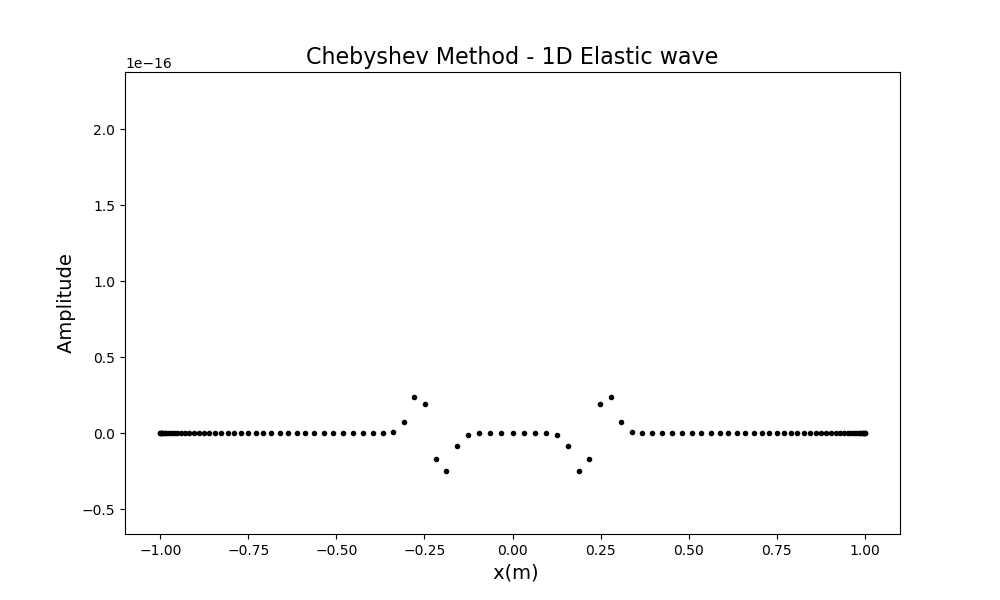

In [5]:
# Initialize animated plot
# ---------------------------------------------------------------
plt.figure(figsize=(10,6))
line = plt.plot(x, p, 'k.', lw=2)
plt.title('Chebyshev Method - 1D Elastic wave', size=16)
plt.xlabel(' x(m)', size=14)
plt.ylabel(' Amplitude ', size=14)

plt.ion() # set interective mode
plt.show()
# ---------------------------------------------------------------
# Time extrapolation
# ---------------------------------------------------------------
# Differentiation matrix
D = get_cheby_matrix(nx)
for it in range(nt):
    # Space derivatives
    dp = np.dot(D, p.T)
    dp = mu/rho * dp
    dp = D @ dp
    
    # Time extrapolation 
    pnew = 2*p - pold + np.transpose(dp) * dt**2
    
    # Source injection
    pnew = pnew + sg*src[it]*dt**2/rho
    
    # Remapping
    pold, p = p, pnew
    p[0] = 0; p[nx] = 0 # set boundaries pressure free 

    # --------------------------------------   
    # Animation plot. Display solution
    if not it % iplot: 
        for l in line:
            l.remove()
            del l               
            
        # -------------------------------------- 
        # Display lines
        line = plt.plot(x, p, 'k.', lw=1.5)
        plt.gcf().canvas.draw()